In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

In [3]:
# Read and prepare data
df = pd.read_csv(r"E:\Projects\walmart_analytics\Cleaned Data\cleaned_data.csv")
df["date"] = pd.to_datetime(df["date"])


Data Analysis:
Minimum value: 0.0
Maximum value: 110754.16
Number of negative values: 0


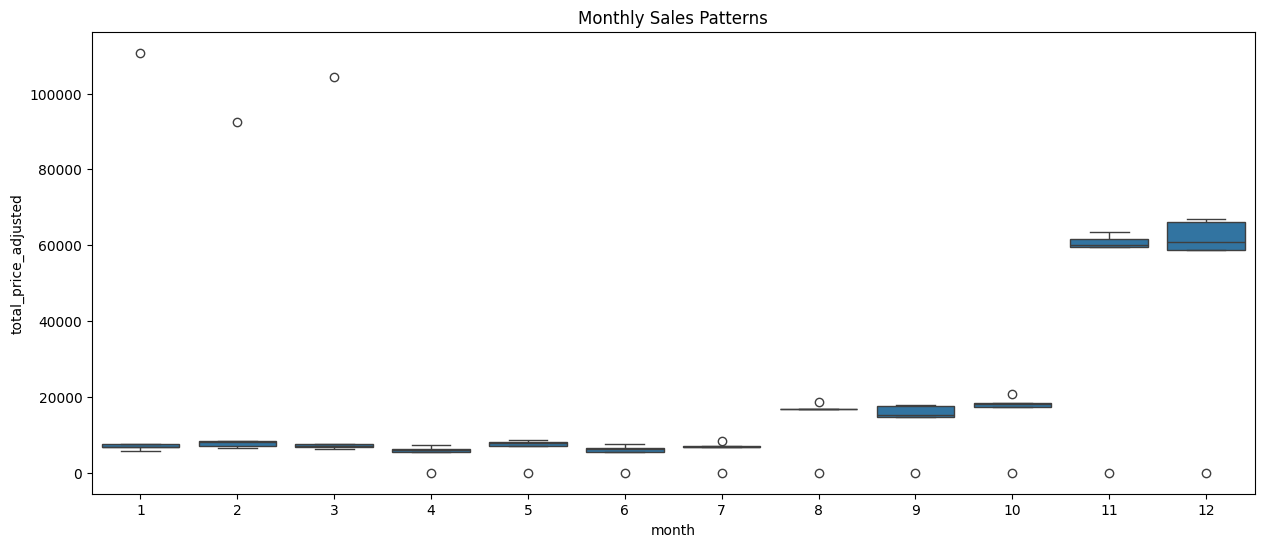

In [6]:
# monthly aggregation
monthly_data = (
    df.groupby(pd.Grouper(key="date", freq="M"))
    .agg({"total_price": "sum", "quantity": "sum", "unit_price": "mean"})
    .reset_index()
)
monthly_data.set_index("date", inplace=True)
monthly_data["month"] = monthly_data.index.month
monthly_data["quarter"] = monthly_data.index.quarter


print("\nData Analysis:")
print("Minimum value:", monthly_data["total_price"].min())
print("Maximum value:", monthly_data["total_price"].max())
print("Number of negative values:", sum(monthly_data["total_price"] < 0))

if monthly_data["total_price"].min() < 0:
    shift_factor = abs(monthly_data["total_price"].min()) + 1
    monthly_data["total_price_adjusted"] = monthly_data["total_price"] + shift_factor
else:
    monthly_data["total_price_adjusted"] = monthly_data["total_price"]

plt.figure(figsize=(15, 6))
sns.boxplot(x="month", y="total_price_adjusted", data=monthly_data)
plt.title("Monthly Sales Patterns")
plt.show()


In [7]:
#  train and test
train_size = int(len(monthly_data) * 0.8)
train = monthly_data["total_price_adjusted"][:train_size]
test = monthly_data["total_price_adjusted"][train_size:]


In [10]:
# Grid search for parameters
def optimize_hw_model(train, test, seasonal_periods=12):
    """Optimize Holt-Winters model parameters"""
    best_rmse = float("inf")
    best_model = None
    best_params = None
    alphas = [0.1, 0.2, 0.3]
    betas = [0.1, 0.2, 0.3]
    gammas = [0.1, 0.2, 0.3]

    for alpha in alphas:
        for beta in betas:
            for gamma in gammas:
                try:
                    model = ExponentialSmoothing(
                        train,
                        trend="add",
                        seasonal="add",
                        seasonal_periods=seasonal_periods,
                    ).fit(
                        smoothing_level=alpha,
                        smoothing_trend=beta,
                        smoothing_seasonal=gamma,
                    )

                    predictions = model.forecast(len(test))
                    rmse = np.sqrt(mean_squared_error(test, predictions))

                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_model = model
                        best_params = {"alpha": alpha, "beta": beta, "gamma": gamma}
                except:
                    continue

    return best_model, best_params, best_rmse



In [11]:
# Optimized model
print("\nOptimizing Holt-Winters model...")
best_model, best_params, best_rmse = optimize_hw_model(train, test)
predictions = best_model.forecast(len(test))
future_forecast = best_model.forecast(12)


Optimizing Holt-Winters model...


In [12]:
#  metrics
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print("\nBest Model Parameters:")
print(f"Alpha (level): {best_params['alpha']}")
print(f"Beta (trend): {best_params['beta']}")
print(f"Gamma (seasonal): {best_params['gamma']}")

print("\nModel Performance Metrics:")
print(f"RMSE: {best_rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")



Best Model Parameters:
Alpha (level): 0.1
Beta (trend): 0.3
Gamma (seasonal): 0.3

Model Performance Metrics:
RMSE: 9005.73
MAE: 6044.06
MAPE: 54.32%


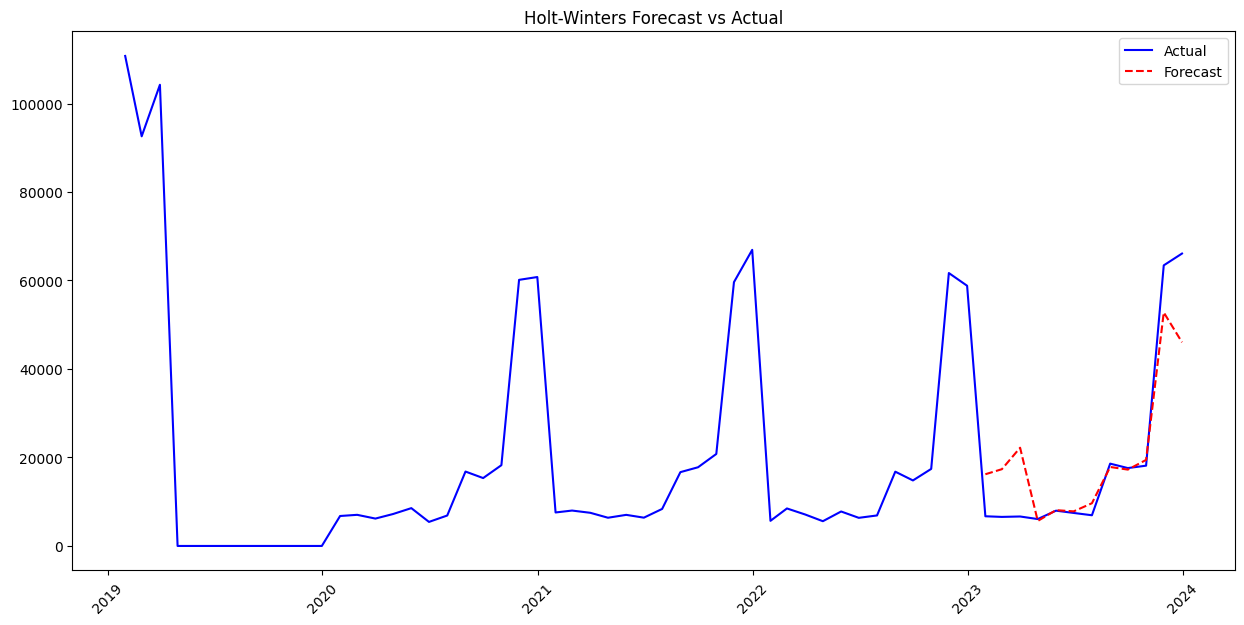

In [13]:

plt.figure(figsize=(15, 7))
plt.plot(
    monthly_data.index,
    monthly_data["total_price_adjusted"],
    label="Actual",
    color="blue",
)
plt.plot(test.index, predictions, label="Forecast", color="red", linestyle="--")
plt.title("Holt-Winters Forecast vs Actual")
plt.legend()
plt.xticks(rotation=45)
plt.show()

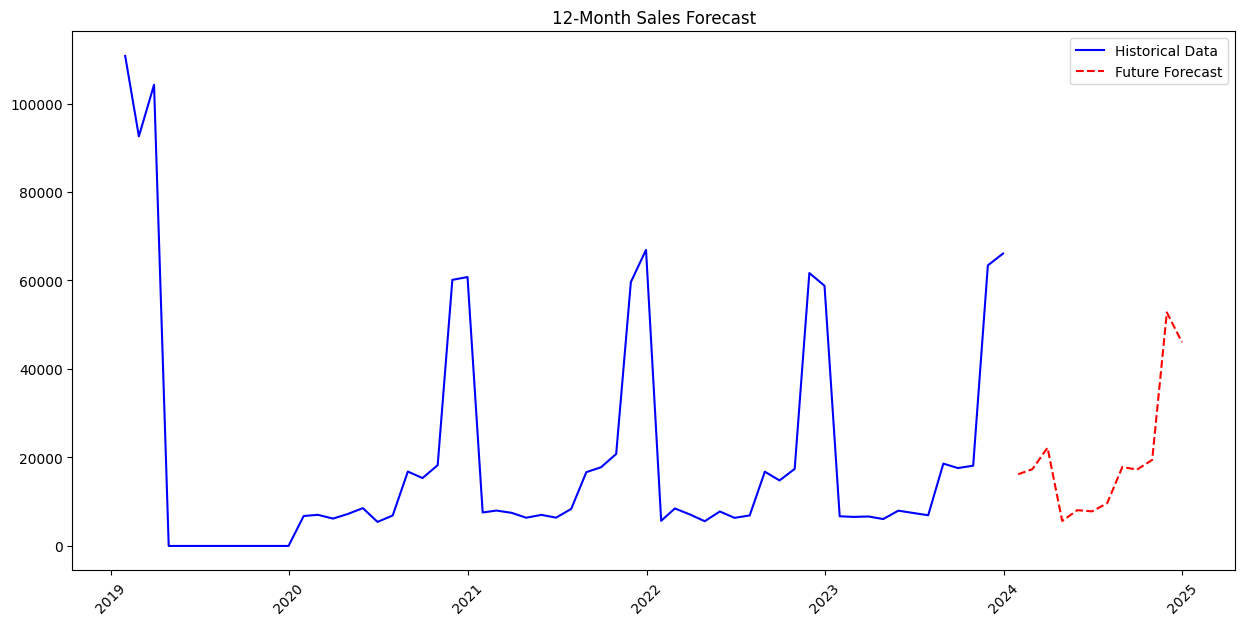

In [14]:
# future forecast
future_index = pd.date_range(start=monthly_data.index[-1], periods=13, freq="M")[1:]

plt.figure(figsize=(15, 7))
plt.plot(
    monthly_data.index,
    monthly_data["total_price_adjusted"],
    label="Historical Data",
    color="blue",
)
plt.plot(
    future_index, future_forecast, label="Future Forecast", color="red", linestyle="--"
)
plt.title("12-Month Sales Forecast")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [15]:
#prediction intervals
residuals = best_model.resid
residual_std = np.std(residuals)
confidence_interval = 1.96 * residual_std  # 95% confidence interval
print("\nForecast Values for Next 12 Months:")
print("Month\t\tForecast\tLower CI\tUpper CI")
print("-" * 60)
for date, forecast in zip(future_index, future_forecast):
    lower_ci = forecast - confidence_interval
    upper_ci = forecast + confidence_interval

    if "shift_factor" in locals():
        forecast = forecast - shift_factor
        lower_ci = lower_ci - shift_factor
        upper_ci = upper_ci - shift_factor

    print(f"{date.strftime('%Y-%m')}\t{forecast:.2f}\t{lower_ci:.2f}\t{upper_ci:.2f}")



Forecast Values for Next 12 Months:
Month		Forecast	Lower CI	Upper CI
------------------------------------------------------------
2024-01	16209.93	-39164.89	71584.75
2024-02	17346.19	-38028.63	72721.01
2024-03	22199.45	-33175.37	77574.27
2024-04	5652.13	-49722.69	61026.95
2024-05	8093.01	-47281.81	63467.83
2024-06	7816.63	-47558.19	63191.45
2024-07	9655.23	-45719.59	65030.05
2024-08	17850.94	-37523.88	73225.76
2024-09	17255.97	-38118.85	72630.79
2024-10	19446.90	-35927.92	74821.71
2024-11	52786.16	-2588.66	108160.98
2024-12	46041.45	-9333.37	101416.27


In [16]:
# Additional analysis
monthly_growth = monthly_data["total_price"].pct_change()
print("\nMonthly Growth Statistics:")
print(monthly_growth.describe())
seasonal_strength = monthly_data.groupby("month")["total_price"].mean()
print("\nSeasonal Pattern Strength:")
print(seasonal_strength)



Monthly Growth Statistics:
count    51.000000
mean           inf
std            NaN
min      -1.000000
25%      -0.088799
50%       0.042066
75%       0.287234
max            inf
Name: total_price, dtype: float64

Seasonal Pattern Strength:
month
1     27496.232
2     24533.576
3     26338.468
4      5053.600
5      6268.200
6      5129.000
7      5816.000
8     13778.800
9     13108.600
10    14922.400
11    48977.000
12    50523.400
Name: total_price, dtype: float64
